## Klasyfikacja ręcznie pisanych liczb - MNIST

Po wykonaniu poprzedniego zadania zleceniodawca znów zadzwonił do Ciebie z kolejnym zadaniem. Okazuje się, że nie wszystkie informacje trafiły do zbioru Tytanic. Brakowało w nim między innymi informacji o pokojach w których mieszkali pasażerowie. Wszystkie informacje o miejscu spania były bowiem zapisane odręcznie na kartkach. Tajemniczy  więc zlecił Ci nowe zadanie... **Stworzenie konwolucyjnej sieci neuronowej rozpoznającej ręcznie pisane cyfry.**

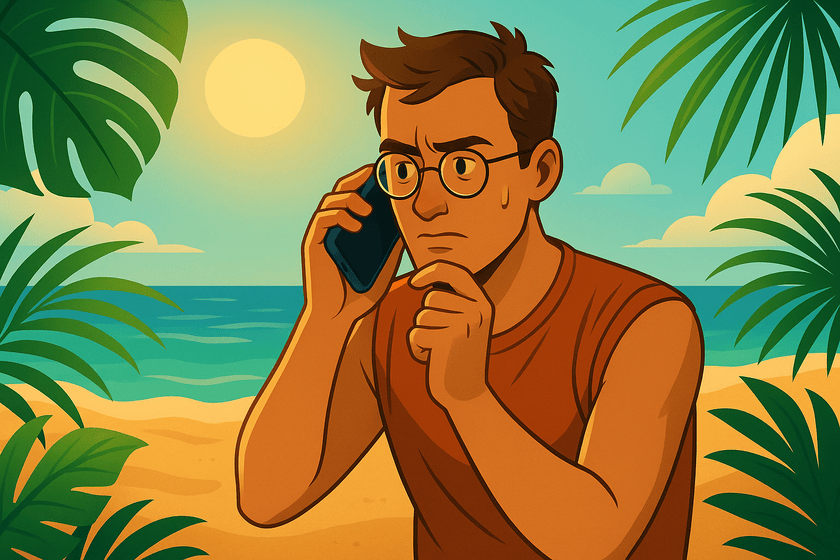

(*AI-generated image*)


#### Twoim celem będzie jest wytrenowanie modelu widzenia komputerowego (CNN) do klasyfikacji każdej ręcznie pisanej liczby z jak najlepszą dokładnością.

Poniżej znajdziesz pytania, które mogą być pomocne w zadaniu:

- Co mój model robi i w jaki sposób?
- Na czym skupia się mój model?
- Jakie liczby mój model myli? Dlaczego?
- Jak uodpornić mój model?
- Jaki wynik klasyfikacji możemy uznać za *dobry*?


Wymagania:
- Wypisz obserwacje z pierwszego zadania, które pomogą Ci w tym. Co było przydatne, a co okazało się bezużyteczne?
- Stwórz baseline, czyli dla porównania sprawdź jak z zadaniem radzi sobie zwykła sieć (nie musi być na wszystkich próbkach - zajmie to długo)
- W badaniach użyj wybranych metryk. Wybór uzasadnij.
- Spróbuj dobrać strukture sieci (szerokość i wysokość) i sprawdź jaki ma wpływ na dokładność
- Ćwiczenie: zmień liczbę kanałów/warstw, dodaj BatchNorm, spróbuj zwiększyć/zmniejszyć dropout.
- Wypisz wnioski.
- Korzystaj z `PyTorch` (`torch, torchvision`)

Niezmiennie, zadbaj o czytelność kodu i nazewnictwo zmiennych. Jeśli jakiś wycinek kodu się powtarza, to wyodrębnij go do funkcji. Postaraj się zamieszczać swoje wnioski w postaci komentarza `Markdown`.

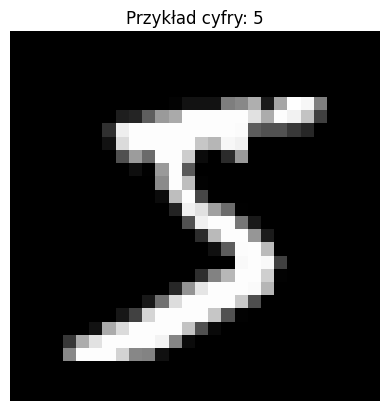

In [27]:
# ładowanie zbioru danych
import tensorflow as tf
import matplotlib.pyplot as plt
import torch

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()


plt.imshow(x_train[0], cmap='gray')
plt.title(f"Przykład cyfry: {y_train[0]}")
plt.axis('off')
plt.show()



---
Tworzymy z danych tensory

---



In [28]:
x_train = torch.tensor(x_train, dtype=torch.float32).unsqueeze(1)
y_train = torch.tensor(y_train)
x_test = torch.tensor(x_test, dtype=torch.float32).unsqueeze(1)
y_test = torch.tensor(y_test)

In [29]:
x_test.shape

torch.Size([10000, 1, 28, 28])

In [30]:
from torch.utils.data import DataLoader, TensorDataset

---
Tworzymy dataset z podanych danych i wprowadzamy `DataLoader` by nakarmić nasz model partiami `batches`

---



In [31]:
train_data = TensorDataset(x_train, y_train)
test_data = TensorDataset(x_test, y_test)

In [32]:
BATCH_SIZE=100
loaders = {
    "train" : DataLoader(train_data,
                         batch_size = BATCH_SIZE,
                         shuffle = True,
                         num_workers = 2,
                         pin_memory = True,
                         ),
    "test" : DataLoader(test_data,
                        batch_size = BATCH_SIZE,
                        shuffle = True,
                        num_workers = 2,
                        pin_memory = True,
                         ),
}

---

Podgląd obrazów i etykiet

---

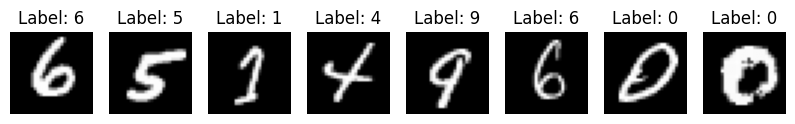

In [33]:
images, labels = next(iter(loaders['train']))
images = images[:8]
labels = labels[:8]

fig,axes = plt.subplots(1, len(images), figsize=(10, 6))
for ax, img, lab in zip(axes, images, labels):
  ax.imshow(img.squeeze().numpy(), cmap='gray')
  ax.set_title(f"Label: {lab.item()}")
  ax.axis('off')
plt.show()

In [34]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

---
Tworzymy prostą sieć neuronową jako baseline dla późniejszego CNN
definiujemy w tym dwie funkcje

po inicjalizacji

1.   pierwsza warstawa przyjmuje ona wielkość spłaszczonego obrazu 28*28=784 pikseli które później przemienia i wyrzuca je na wyście 100 neuronów
2.  druga warstaw liniowa przyjmuje nam na wejście 100 neuronów i zmniejsza nam do 50 neuronów na wyjściu
3. trzecia warstaw liniowa przyjmuje na wejście 50 neuronów na wejściu i zwraca na wyjściu 10 neuronów czyli opowiednik naszego [0-9]

natomiast forward zajmuje się
spłaszczeniem obrazu do wektora długości 784
stosujemy na relu na warstwe 1
potem znowu relu na warstwe 2
po czym zwracamy x przepuszczonego przez warstwę 3 bez relu bo już nie jest to potrzebne gdyż na wyjściu warstwy 3 mamy liczby od [0-9]

---


In [35]:
class BaselineNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 100)
        self.fc2 = nn.Linear(100, 50)
        self.fc3 = nn.Linear(50, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

---
Tworzymy docelowy model CNN

Po inicjalizacji

pierwsza warstwa konwolucyjna przyjmuje 1 kanał (ponieważ nasze obrazy są czarno białe) i zwraca 10 map cech przy filtrze 5x5 pikseli

druga warstawa konwolucyjna przyjmuje 10 kanałów (wcześniejsze 10 map cech)

`conv2_drop` stosujemy by zapobiec przeuczeniu

no i jak wcześniej w baseline sostujemy warstwy liniowe

w forwardzie zaczynamy od przepuszczenia obrazu przez pierwszą konwolucje
następnie przepuszczamy przez `max_pool` w celu zmniejszenia cech o połowę i na koniec stosujemy relu

po czym ponawiamy dla drugiej warstwy konwolucyjnej

następnie spłaszczenie map cech i zastosowanie warstwy liniowej z relu
dropout żeby zapobiec przeuczeniu
no i na sam koniec dostajemy wartości [0-9]



---

In [36]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN,self).__init__()

    self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
    self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
    self.conv2_drop = nn.Dropout2d()
    self.fcl = nn.Linear(320, 50)
    self.fc2 = nn.Linear(50, 10)

  def forward(self, x):
    x = F.relu(F.max_pool2d(self.conv1(x), 2))
    x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
    x = x.view(-1, 320)
    x = F.relu(self.fcl(x))
    x = F.dropout(x, training=self.training)
    x = self.fc2(x)

    return x

---
Kod eksperymentowy

---

In [37]:
"""
class BaselineNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 256)   # więcej neuronów
        self.bn1 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 128)     # więcej neuronów
        self.bn2 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(0.3)     # zmniejszony dropout

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = self.fc3(x)
        return x


 class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)   # więcej kanałów
        self.bn1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # dodatkowa warstwa
        self.bn3 = nn.BatchNorm2d(128)

        self.dropout = nn.Dropout(0.4)  # mocniejszy dropout na FC
        self.fc1 = nn.Linear(128 * 3 * 3, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2)

        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2)

        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, 2)

        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x
"""


'\nclass BaselineNN(nn.Module):\n    def __init__(self):\n        super().__init__()\n        self.fc1 = nn.Linear(28*28, 256)   # więcej neuronów\n        self.bn1 = nn.BatchNorm1d(256)\n        self.fc2 = nn.Linear(256, 128)     # więcej neuronów\n        self.bn2 = nn.BatchNorm1d(128)\n        self.fc3 = nn.Linear(128, 10)\n        self.dropout = nn.Dropout(0.3)     # zmniejszony dropout\n\n    def forward(self, x):\n        x = x.view(-1, 28*28)\n        x = F.relu(self.bn1(self.fc1(x)))\n        x = self.dropout(x)\n        x = F.relu(self.bn2(self.fc2(x)))\n        x = self.dropout(x)\n        x = self.fc3(x)\n        return x\n\n\n class CNN(nn.Module):\n    def __init__(self):\n        super(CNN, self).__init__()\n        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)   # więcej kanałów\n        self.bn1 = nn.BatchNorm2d(32)\n\n        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)\n        self.bn2 = nn.BatchNorm2d(64)\n\n        self.conv3 = nn.Conv2d(64, 1

---

funkcja train odpala model w trybie train
następnie iterujemy i przenosimy na na cpu albo gpu
zerujemy gradienty,przepuszczmy przez sieć neuronową  liczymy funkcje starty i obliczmay gradient i aktualizujemy wagi na podstawie gradientów

Co 20 batchy zostaje wyprintowany stan treningu.

w  fukcji evaluate wyłączamy gradienty
przepuszczamy batch przez model następnie
liczym stratę i sumuje,wybiera klasę o największym prawdopodobieństwie
na samym końcu sprawdza poprawność predykcji.



---

In [38]:
baseline_losses, baseline_accuracies = [], []
cnn_losses, cnn_accuracies = [], []

def train(model, optimizer, epoch, model_name):
    model.train()
    for batch_idx, (data, target) in enumerate(loaders['train']):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()

        if batch_idx % 20 == 0:
            print(f"{model_name} Train Epoch: {epoch} "
                  f"[{batch_idx * len(data)}/{len(loaders['train'].dataset)} "
                  f"({100. * batch_idx / len(loaders['train']):.0f}%)]\tLoss: {loss.item():.6f}")

def evaluate(model, loss_fn, model_name):
    model.eval()
    total_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in loaders['test']:
            data, target = data.to(device), target.to(device)
            output = model(data)
            total_loss += loss_fn(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    avg_loss = total_loss / len(loaders['test'])
    accuracy = 100. * correct / len(loaders['test'].dataset)

    if model_name == "Baseline":
        baseline_losses.append(avg_loss)
        baseline_accuracies.append(accuracy)
    else:
        cnn_losses.append(avg_loss)
        cnn_accuracies.append(accuracy)

    print(f"\n{model_name} set: Average loss: {avg_loss:.4f}, "
          f"Accuracy: {correct}/{len(loaders['test'].dataset)} ({accuracy:.2f}%)\n")

---

Wykresy przebiegu uczenia porównujące Baseline z CNN

---

In [39]:
def plot_metrics():
    plt.figure(figsize=(12,5))

    # Loss
    plt.subplot(1,2,1)
    plt.plot(baseline_losses, label="Baseline Loss")
    plt.plot(cnn_losses, label="CNN Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Loss")

    # Accuracy
    plt.subplot(1,2,2)
    plt.plot(baseline_accuracies, label="Baseline Accuracy")
    plt.plot(cnn_accuracies, label="CNN Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy [%]")
    plt.legend()
    plt.title("Accuracy")

    plt.show()

---
Trenujemy modele

---

In [40]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

baseline_model = BaselineNN().to(device)
cnn_model = CNN().to(device)

loss_fn = nn.CrossEntropyLoss()

opt_baseline = optim.Adam(baseline_model.parameters(), lr=0.001)
opt_cnn = optim.Adam(cnn_model.parameters(), lr=0.001)

for epoch in range(1, 6):  # np. 5 epok
    train(baseline_model, opt_baseline, epoch, "Baseline")
    evaluate(baseline_model, loss_fn, "Baseline")

    train(cnn_model, opt_cnn, epoch, "CNN")
    evaluate(cnn_model, loss_fn, "CNN")



Baseline Train Epoch: 1 [0/60000 (0%)]	Loss: 8.213281
Baseline Train Epoch: 1 [2000/60000 (3%)]	Loss: 0.999883
Baseline Train Epoch: 1 [4000/60000 (7%)]	Loss: 0.388693
Baseline Train Epoch: 1 [6000/60000 (10%)]	Loss: 0.384178
Baseline Train Epoch: 1 [8000/60000 (13%)]	Loss: 0.526664
Baseline Train Epoch: 1 [10000/60000 (17%)]	Loss: 0.385431
Baseline Train Epoch: 1 [12000/60000 (20%)]	Loss: 0.318276
Baseline Train Epoch: 1 [14000/60000 (23%)]	Loss: 0.240830
Baseline Train Epoch: 1 [16000/60000 (27%)]	Loss: 0.548493
Baseline Train Epoch: 1 [18000/60000 (30%)]	Loss: 0.209374
Baseline Train Epoch: 1 [20000/60000 (33%)]	Loss: 0.055359
Baseline Train Epoch: 1 [22000/60000 (37%)]	Loss: 0.192076
Baseline Train Epoch: 1 [24000/60000 (40%)]	Loss: 0.246702
Baseline Train Epoch: 1 [26000/60000 (43%)]	Loss: 0.351840
Baseline Train Epoch: 1 [28000/60000 (47%)]	Loss: 0.215863
Baseline Train Epoch: 1 [30000/60000 (50%)]	Loss: 0.396409
Baseline Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.199021
Baseline

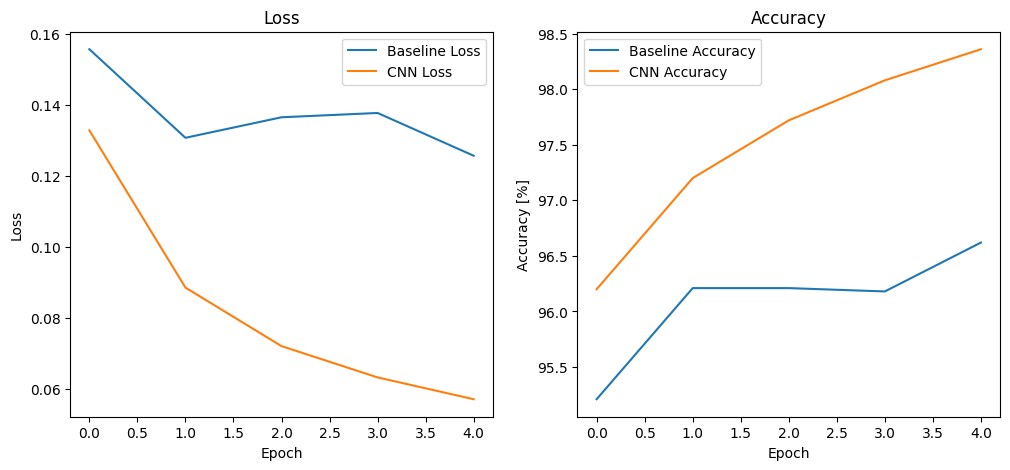

In [41]:
plot_metrics()

In [42]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

---
Wyliczamy confusion matrix

---

In [43]:
def compute_confusion_matrix(model, loader):
    model.eval()
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for data, target in loader:
            data = data.to(device)
            output = model(data)
            preds = output.argmax(dim=1).cpu().numpy()
            all_preds.append(preds)
            all_targets.append(target.numpy())
    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)
    cm = confusion_matrix(all_targets, all_preds, labels=list(range(10)))
    return cm, all_preds, all_targets


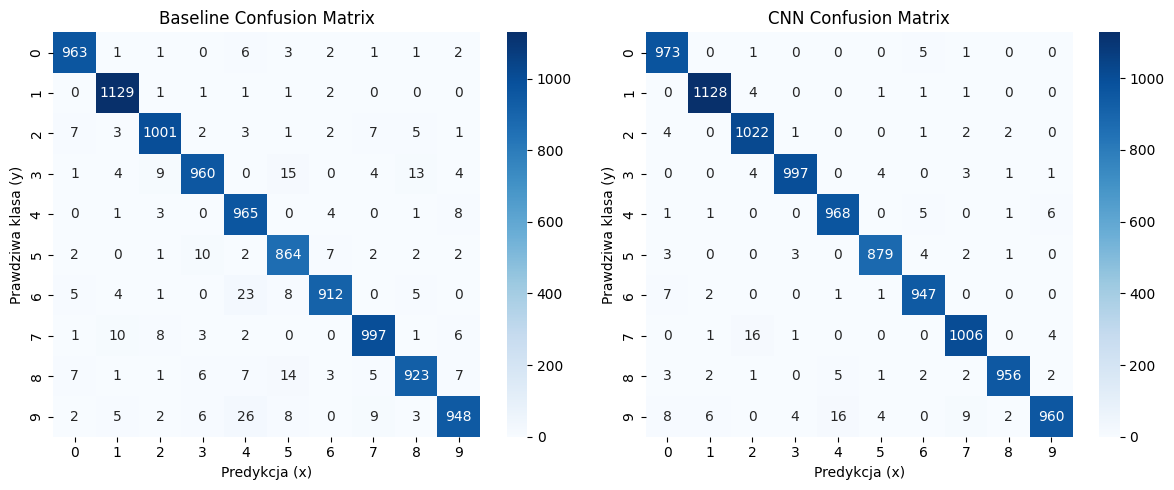

In [44]:
cm_baseline, preds_baseline, targets_baseline = compute_confusion_matrix(baseline_model, loaders['test'])
cm_cnn, preds_cnn, targets_cnn = compute_confusion_matrix(cnn_model, loaders['test'])

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(cm_baseline, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_xlabel('Predykcja (x)')
axes[0].set_ylabel('Prawdziwa klasa (y)')
axes[0].set_title('Baseline Confusion Matrix')

sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_xlabel('Predykcja (x)')
axes[1].set_ylabel('Prawdziwa klasa (y)')
axes[1].set_title('CNN Confusion Matrix')

plt.tight_layout()
plt.show()

In [45]:
print("Baseline classification report:")
print(classification_report(targets_baseline, preds_baseline, digits=4))

print("CNN classification report:")
print(classification_report(targets_cnn, preds_cnn, digits=4))

Baseline classification report:
              precision    recall  f1-score   support

           0     0.9747    0.9827    0.9787       980
           1     0.9750    0.9947    0.9847      1135
           2     0.9737    0.9700    0.9718      1032
           3     0.9717    0.9505    0.9610      1010
           4     0.9324    0.9827    0.9569       982
           5     0.9453    0.9686    0.9568       892
           6     0.9785    0.9520    0.9651       958
           7     0.9727    0.9698    0.9713      1028
           8     0.9675    0.9476    0.9575       974
           9     0.9693    0.9395    0.9542      1009

    accuracy                         0.9662     10000
   macro avg     0.9661    0.9658    0.9658     10000
weighted avg     0.9665    0.9662    0.9662     10000

CNN classification report:
              precision    recall  f1-score   support

           0     0.9740    0.9929    0.9833       980
           1     0.9895    0.9938    0.9916      1135
           2     0.

---
Na podstawie danych możemy dostrzec że model CNN osiąga lepsza precyzje `98.2%` w porówaniu do modelu baseline mimo tego widać że CNN źle sobie radzi z rozpoznawaniem `7`, `8`, `9`.

Problemy z `8` i `9` można zrozumieć bo są to wyjątkowo do siebie podobne cyfry lecz dziwi problem z rozpoznawaniem `7`.

---

---
Tworzymy wizualizacje predykcji

---

In [46]:
def pred_vis(model,test_loader):
  model.eval()
  images, labels = next(iter(test_loader))
  images, labels = images[:8], labels[:8]
  with torch.no_grad():
    logits = model(images.to(device))
  preds = logits.argmax(1).cpu()

  fig, axes = plt.subplots(1, len(images), figsize=(12, 2.5))
  for ax, img, y, p in zip(axes, images, labels, preds):
    ax.imshow(img.squeeze().numpy(), cmap="gray")
    ax.set_title(f"y={y.item()} / p={int(p)}")
    ax.axis("off")

  plt.show()


 Prediction visualization (cnn_model):



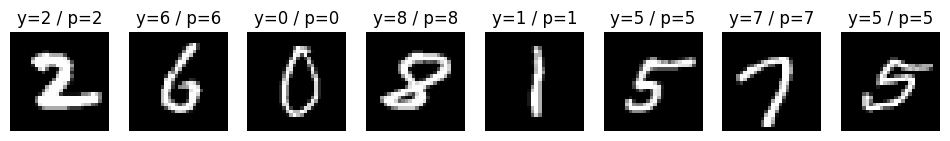

In [47]:
print(f"\n Prediction visualization (cnn_model):\n")
pred_vis(cnn_model, loaders['test'])